# 1 - Synthetic Data Generation and Exploration
*By Marcus Schwarting and Andronicus Samsundar Rajasukumar*

In this notebook, we will:
- Generate random datasets that cover a number of types (str, bool, int, float)
- Demonstrate using the `Card_Dataset` class to generate queries and gather cardinalities
- Show how featurized queries and corresponding cardinalities can be phrased as a supervised learning (SL) problem
- Train simple supervised learning algorithms to perform predictions on our random dataset.

In [32]:
from cardinality_data_read import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from string import ascii_uppercase
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

### Generating A Random Dataset
We begin by defining a random dataset. We construct a "master" table, then break into five tables with selected (often-overlapping) attributes. For a specific attribute, a type is selected and data is generated accordingly. For example, for an attribute `X`, the type may be randomly selected as `string`. In such a case, a set of random strings are generated and procedurally selected to populate the column. This process is iterated over all attributes to fill out the "master" table. Tables are generated from subsets of randomly selected attributes.

In [2]:
attributes = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n',\
              'o','p','q','r','s','t','u','v','w','x','y','z']

dist_select = np.random.choice(['float_gauss','float_uniform','string','int','bool'],len(attributes))


all_data = []
data_points_count = 10**3
act_types_li = []
for i in dist_select:
    if i=='float_gauss': #Use a Gaussian distribution
        mean = np.random.uniform(-100,100,1)[0]
        stdev = np.random.uniform(10,50,1)[0]
        all_data.append(np.random.normal(mean,stdev,data_points_count))
        act_types_li.append(float)
    elif i=='float_uniform': #Use a Uniform distribution
        bounds = np.random.uniform(-1000,1000,2)
        lower = min(bounds)
        upper = max(bounds)
        all_data.append(np.random.uniform(lower,upper,data_points_count))
        act_types_li.append(float)
    elif i=='string':
        num_rand_strings = np.random.choice(range(5,11),1)[0]
        rand_strings = [''.join(choice(ascii_uppercase) for i in range(12)) \
                                for i in range(num_rand_strings)]
        all_data.append(np.random.choice(rand_strings,data_points_count))
        act_types_li.append(str)
    elif i=='int':
        bounds = np.random.uniform(-1000,1000,2)
        lower = int(min(bounds))
        upper = int(max(bounds))
        all_data.append(np.random.choice(range(lower,upper+1),data_points_count))
        act_types_li.append(int)
    elif i=='bool':
        all_data.append(np.random.choice([True,False],data_points_count))
        act_types_li.append(bool)
        
types_dict = {}
for i in range(len(act_types_li)):
    types_dict[attributes[i]]=act_types_li[i]


full_df = pd.DataFrame(np.array(all_data).T,columns=attributes)
full_df = full_df.astype(types_dict)
full_df



,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
0,59.521981,-538.393251,345.588857,427,True,-37.357485,-72.278951,564.290845,-62.041744,160.359272,...,-488.000936,15,10.664793,JMRGOTCXPKRD,XHZNMXCITCOU,-19.390678,-110.948725,-9.691315,-34.455063,TJMLZFOHZJYC
1,93.884556,-524.411364,-251.368433,409,True,-39.053187,-113.630925,577.724143,-77.676244,133.194321,...,-416.801124,70,-0.760175,JMRGOTCXPKRD,TENIHRUUAZDX,-85.191685,13.440247,18.462685,-318.212466,WNWNKFJRQCGA
2,-6.576285,-102.987570,-162.329186,401,True,-63.365687,-27.506663,589.265709,-94.539807,43.018341,...,210.848808,106,-121.150490,SXGRCWHGOEQO,XHZNMXCITCOU,-28.954861,46.531002,61.530567,-114.325447,WNWNKFJRQCGA
3,55.241552,416.227710,-218.449705,704,True,-47.558368,-58.595477,644.290125,-67.381414,-11.362048,...,-45.775070,134,9.112289,CIMMGRUIBPPW,YSCVIEVFRPSB,-81.047121,64.384391,2.898450,-377.151814,QTCHBVUGNBUK
4,-0.890401,78.626124,157.649457,697,True,-51.222790,38.753728,501.925437,-81.032283,120.988525,...,-10.344466,90,17.524103,DLFVRWGYJVAN,CAWPINJWHXJB,-101.333956,88.674026,22.170930,-398.691411,WNWNKFJRQCGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.703583,-167.761319,-265.887771,442,True,-86.676610,-35.722762,547.036376,-92.648502,90.173451,...,-493.419124,6,-82.326207,DLFVRWGYJVAN,LOGLDJBAJPZH,-41.239938,21.214997,-37.638727,-340.523944,TJMLZFOHZJYC
996,59.894717,409.174635,323.621932,439,True,-52.869839,12.764196,626.544986,-103.869673,50.095795,...,-55.007842,-57,22.448175,JMRGOTCXPKRD,CAWPINJWHXJB,-28.880322,33.699201,-112.189173,-308.192663,YFJFNPNGDLKE
997,20.786764,422.474221,-11.872174,414,True,-80.221643,-11.608315,486.824141,-104.157713,113.262380,...,-273.770174,170,-39.975105,QCMBMIVWXOBS,XHZNMXCITCOU,-42.947201,37.394615,-2.433743,-203.219940,SOTVPEBZRSAN
998,41.248865,-351.277379,-375.044990,409,True,-88.995593,3.734123,516.909255,-79.658575,81.666508,...,-573.988553,202,-21.137790,PWIUAVDHMMJA,FHYRXZEGFKUG,-45.543830,57.145205,24.700399,-380.546648,SEPSMZBTQMYN


### Generating Tables from the Master
Once the master table has been created, tables are built using selections of the whole.

In [3]:
table_attrs = []
num_tables = 5
tables_dict = {}
for i in range(num_tables):
    #Pick random number of attrs in table
    num_attrs = np.random.choice(range(3,8),1)[0]
    selected_attrs = sorted(np.random.choice(attributes,num_attrs,replace=False))
    table_attrs.append(selected_attrs)
    tables_dict[i]=full_df[selected_attrs]

for i in tables_dict.keys():
    print(i,tables_dict[i].columns.tolist())

0 ['d', 'e', 't', 'v']
1 ['d', 'o', 'y', 'z']
2 ['f', 'g', 'm', 'n', 's', 'u', 'y']
3 ['c', 'h', 'p', 'r', 's', 'v', 'w']
4 ['d', 'e', 'f', 'g', 'l', 't', 'z']


### Cardinality Dataset Class
We introduce a class that allows for data to be read in and random queries with their corresponding cardinalities to be identified.

In [4]:
card_test1 = Card_Dataset(join_lim=4, num_predicate_lim=4, non_num_predicate_lim=0)
for i in tables_dict.keys():
    card_test1.add_table(tables_dict[i],name=f'table_{i}')

card_test1.featurize_space(verbose=True)

All Table Names:
['table_0' 'table_1' 'table_2' 'table_3' 'table_4']

All Enumerated Joins:
['join-attr-table_0.d-to-table_1.d' 'join-attr-table_0.v-to-table_3.v'
 'join-attr-table_0.d-to-table_4.d' 'join-attr-table_0.e-to-table_4.e'
 'join-attr-table_0.t-to-table_4.t' 'join-attr-table_1.y-to-table_2.y'
 'join-attr-table_1.d-to-table_4.d' 'join-attr-table_1.z-to-table_4.z'
 'join-attr-table_2.s-to-table_3.s' 'join-attr-table_2.f-to-table_4.f'
 'join-attr-table_2.g-to-table_4.g']

Numerical Predicate Space:
['table_0.d' 'table_0.e' 'table_0.v' 'table_1.d' 'table_1.o' 'table_1.y'
 'table_2.f' 'table_2.g' 'table_2.m' 'table_2.n' 'table_2.s' 'table_2.y'
 'table_3.c' 'table_3.h' 'table_3.r' 'table_3.s' 'table_3.v' 'table_3.w'
 'table_4.d' 'table_4.e' 'table_4.f' 'table_4.g' '<' '>' '='
 'NORMALIZED_NUM']

Non-Numerical Predicate Space:
['table_0.t' 'table_1.z' 'table_2.u' 'table_3.p' 'table_4.l' 'table_4.t'
 'table_4.z' 'HASHED_INT' 'E_BALL']



### Test 1: Numerical Predicates Only
Current state-of-the-art ML-based cardinality estimators can consider only numerical attributes. Our code allows for non-numerical attributes to be included in both join operations and within predicates. We start with an example that demonstrates predictive power based on features generated with only numerical predicates. Note that when we featurized, we selected `non_num_predicate_lim=0`. This ensures that non-numerical predicates will be omitted in the featurizations.

In [5]:
X1, y1 = card_test1.generate_N_queries(5000)
print('Example of Featurized Query:')
print(X1.tolist()[0])
print(f'Resulting Normalized Cardinality: {y1.tolist()[0]}')

Example of Featurized Query:
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.23351610797431244, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.8579674067816448, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Resulting Normalized Cardinality: 0.114


In [6]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1)

Start with a random forest regressor, breaking our queries into training (80%) and testing (20%).

In [7]:
regr1 = RandomForestRegressor()
regr1.fit(np.array(X1_train),np.array(y1_train))
y1_out_train = regr1.predict(np.array(X1_train))
y1_out_test = regr1.predict(np.array(X1_test))

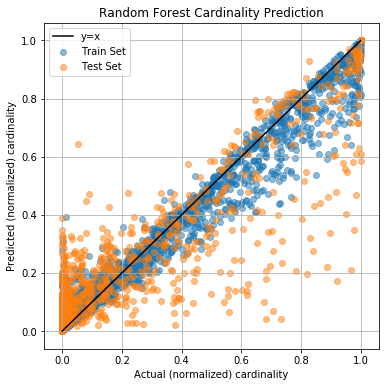

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y1_train,y1_out_train,alpha=0.5,label='Train Set')
plt.scatter(y1_test,y1_out_test,alpha=0.5,label='Test Set')
plt.xlabel('Actual (normalized) cardinality')
plt.ylabel('Predicted (normalized) cardinality')
plt.title('Random Forest Cardinality Prediction')
plt.plot([0,1],[0,1],color='black',label='y=x')
plt.legend()
plt.grid()
plt.show()

In [9]:
print(f'RFR Mean Average Error: {np.average(abs(y1_test-y1_out_test))}')

RFR Mean Average Error: 0.08357579716821532


Next try a support vector machine regressor on the same training and testing set.

In [10]:
regr1 = SVR()
regr1.fit(np.array(X1_train),np.array(y1_train))
y1_out_train = regr1.predict(np.array(X1_train))
y1_out_test = regr1.predict(np.array(X1_test))

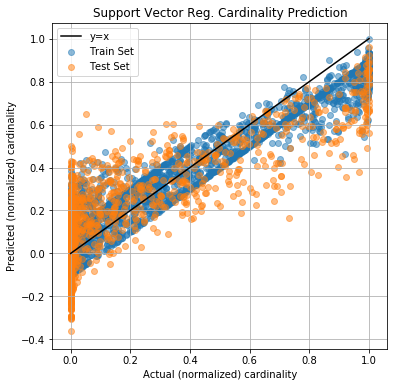

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(y1_train,y1_out_train,alpha=0.5,label='Train Set')
plt.scatter(y1_test,y1_out_test,alpha=0.5,label='Test Set')
plt.xlabel('Actual (normalized) cardinality')
plt.ylabel('Predicted (normalized) cardinality')
plt.title('Support Vector Reg. Cardinality Prediction')
plt.plot([0,1],[0,1],color='black',label='y=x')
plt.legend()
plt.grid()
plt.show()

In [12]:
print(f'SVR Mean Average Error: {np.average(abs(y1_test-y1_out_test))}')

SVR Mean Average Error: 0.13903941974581882


### Test 2: Learning From Non-Numerical Predicates
We run similar tests, but now introduce non-numerical predicates into the feature space. We allow up to two non-numerical predicates 

In [13]:
card_test2 = Card_Dataset(join_lim=2, num_predicate_lim=2, non_num_predicate_lim=2)
for i in tables_dict.keys():
    card_test2.add_table(tables_dict[i],name=f'table_{i}')

card_test2.featurize_space(verbose=True)

All Table Names:
['table_0' 'table_1' 'table_2' 'table_3' 'table_4']

All Enumerated Joins:
['join-attr-table_0.d-to-table_1.d' 'join-attr-table_0.v-to-table_3.v'
 'join-attr-table_0.d-to-table_4.d' 'join-attr-table_0.e-to-table_4.e'
 'join-attr-table_0.t-to-table_4.t' 'join-attr-table_1.y-to-table_2.y'
 'join-attr-table_1.d-to-table_4.d' 'join-attr-table_1.z-to-table_4.z'
 'join-attr-table_2.s-to-table_3.s' 'join-attr-table_2.f-to-table_4.f'
 'join-attr-table_2.g-to-table_4.g']

Numerical Predicate Space:
['table_0.d' 'table_0.e' 'table_0.v' 'table_1.d' 'table_1.o' 'table_1.y'
 'table_2.f' 'table_2.g' 'table_2.m' 'table_2.n' 'table_2.s' 'table_2.y'
 'table_3.c' 'table_3.h' 'table_3.r' 'table_3.s' 'table_3.v' 'table_3.w'
 'table_4.d' 'table_4.e' 'table_4.f' 'table_4.g' '<' '>' '='
 'NORMALIZED_NUM']

Non-Numerical Predicate Space:
['table_0.t' 'table_1.z' 'table_2.u' 'table_3.p' 'table_4.l' 'table_4.t'
 'table_4.z' 'HASHED_INT' 'E_BALL']



In [14]:
X2, y2 = card_test2.generate_N_queries(5000)
print('Example of Featurized Query:')
print(X2.tolist()[0])
print(f'Resulting Normalized Cardinality: {y2.tolist()[0]}')

Example of Featurized Query:
[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.22494209488388994, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.65397242, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97253284, 0.0]
Resulting Normalized Cardinality: 0.0


In [15]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2)

In [22]:
regr2 = RandomForestRegressor()
regr2.fit(np.array(X2_train),np.array(y2_train))
y2_out_train = regr2.predict(np.array(X2_train))
y2_out_test = regr2.predict(np.array(X2_test))

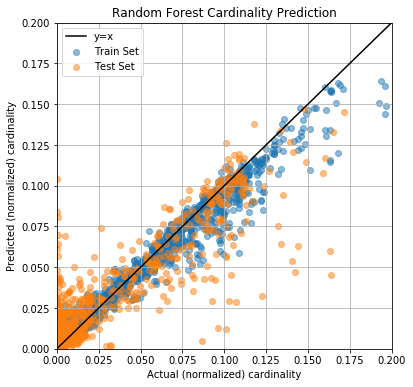

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(y2_train,y2_out_train,alpha=0.5,label='Train Set')
plt.scatter(y2_test,y2_out_test,alpha=0.5,label='Test Set')
plt.xlabel('Actual (normalized) cardinality')
plt.ylabel('Predicted (normalized) cardinality')
plt.title('Random Forest Cardinality Prediction')
plt.plot([0,1],[0,1],color='black',label='y=x')
plt.legend()
plt.xlim([0,0.2])
plt.ylim([0,0.2])
plt.grid()
plt.show()

In [18]:
print(f'RFR Mean Average Error: {np.average(abs(y2_test-y2_out_test))}')

RFR Mean Average Error: 0.008124215531740808


In [33]:
regr2 = KNeighborsRegressor()
regr2.fit(np.array(X2_train),np.array(y2_train))
y2_out_train = regr2.predict(np.array(X2_train))
y2_out_test = regr2.predict(np.array(X2_test))

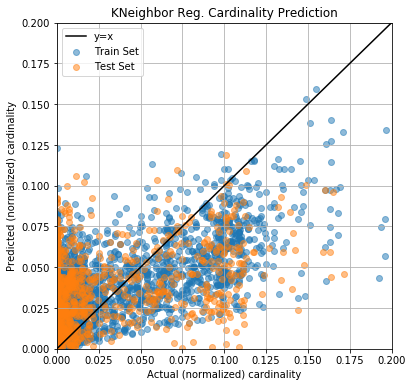

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(y2_train,y2_out_train,alpha=0.5,label='Train Set')
plt.scatter(y2_test,y2_out_test,alpha=0.5,label='Test Set')
plt.xlabel('Actual (normalized) cardinality')
plt.ylabel('Predicted (normalized) cardinality')
plt.title('KNeighbor Reg. Cardinality Prediction')
plt.plot([0,1],[0,1],color='black',label='y=x')
plt.legend()
plt.xlim([0,0.2])
plt.ylim([0,0.2])
plt.grid()
plt.show()

In [35]:
print(f'KNN Mean Average Error: {np.average(abs(y2_test-y2_out_test))}')

KNN Mean Average Error: 0.02625135519901577


### Final Results:
| Predicates Included      | Regression Model | Mean Average Error |
| ----------- | ----------- | ----------- |
| Numeric Only      | Random Forest       | 0.08358 |
| Numeric Only      | Support Vector       | 0.13904 |
| Numeric and Non-Numeric      | Random Forest       | 0.00812 |
| Numeric and Non-Numeric      | KNN Regression      | 0.02625 |

Note that adding non-numeric predicates reduces the number of returns from queries, however it is still promising to see a large reduction in error by adding non-numeric predicates.